# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np

import glob
import cv2

import matplotlib.pyplot as plt

# Load Dataset

In [2]:
list_train_image = glob.glob("C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/train/images/*")
path_train_label = "C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/train/labels/"

list_val_image = glob.glob("C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/valid/images/*")
path_val_label = "C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/valid/labels/"

In [3]:
def data_loader(list_train_image,path_train_label):
    list_train_x = []
    list_train_y = []
    
    for file_image in list_train_image:
        file_name = file_image.split("\\")[1].replace(".jpg","")
        file_label = path_train_label+file_name+".txt"
    
        #Read Image
        img = cv2.imread(file_image)
        #Resize
        img = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
        #Normalize Image
        img = img/255.0
        #Add to list
        list_train_x.append(img)
    
        #Read Label
        label = np.zeros((14,5)) # 14 max object in one image 5 is coff,x,y,w,h
        with open(file_label) as file:
            for i,line in enumerate(file.readlines()):
                _line = line.split()
                x = float(_line[1])
                y = float(_line[2])
                w = float(_line[3])
                h = float(_line[4])
                label[i] = np.array([1.0,x,y,w,h])
        label = label.reshape(14*5)
        list_train_y.append(label)
    
    list_train_x = np.asarray(list_train_x)
    list_train_y = np.asarray(list_train_y)
    return list_train_x,list_train_y

In [4]:
train_x,train_y = data_loader(list_train_image,path_train_label)
val_x,val_y = data_loader(list_val_image,path_val_label)

In [5]:
print(f"train_x:{train_x.shape}")
print(f"train_y:{train_y.shape}")
print(f"val_x:{val_x.shape}")
print(f"val_y:{val_y.shape}")

train_x:(4509, 300, 300, 3)
train_y:(4509, 70)
val_x:(1093, 300, 300, 3)
val_y:(1093, 70)


# Build Model

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(70, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [8]:
print(f"Model_input_shape:{model.input_shape}")
print(f"Model_output_shape:{model.output_shape}")

Model_input_shape:(None, 300, 300, 3)
Model_output_shape:(None, 70)


# Train Model

In [9]:
model.compile(optimizer='adam',loss='mae')

filepath = 'model/model_best_val.keras'
save_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True, period=1,mode='min')

history = model.fit(train_x, train_y, epochs=1000,batch_size=32, validation_data=(val_x, val_y),callbacks=[save_checkpoint])

model.save('model/model_final.keras')

Epoch 1/1000
141/141 [==============================] - ETA: 0s - loss: 0.0525
Epoch 1: val_loss improved from inf to 0.01940, saving model to model\model_best_val.keras
141/141 [==============================] - 22s 117ms/step - loss: 0.0525 - val_loss: 0.0194
Epoch 2/1000
141/141 [==============================] - ETA: 0s - loss: 0.0171
Epoch 2: val_loss improved from 0.01940 to 0.01647, saving model to model\model_best_val.keras
141/141 [==============================] - 14s 102ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 3/1000
141/141 [==============================] - ETA: 0s - loss: 0.0151
Epoch 3: val_loss improved from 0.01647 to 0.01575, saving model to model\model_best_val.keras
141/141 [==============================] - 14s 102ms/step - loss: 0.0151 - val_loss: 0.0158
Epoch 4/1000
141/141 [==============================] - ETA: 0s - loss: 0.0143
Epoch 4: val_loss improved from 0.01575 to 0.01546, saving model to model\model_best_val.keras
141/141 [=======================

# Plot Loss

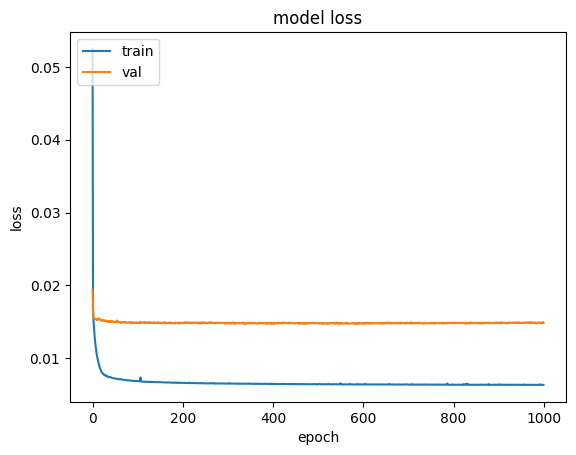

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')